The goal here is to test if using ReLU on the output layer can be an effective way to directly handle the zero-inflated output variable (property damage) without omitting the zero dollar tornado events.

The idea is that this may work because using ReLU on the output layer would allow the model to predict a zero dollar tornado by predicting any value less than or equal to zero.

The effect of oversampling and three different output variable processing methods were also tested.

Oversampling extreme events will artificially allow the model to further learn from those extreme events, and the different processing methods were evaluated because they do not alter the natural scale of the variables as much as the `/Complete_Workflow/` processing method does.

## Setup

In [1]:
# Packages
import pandas as pd
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import pylab
import math
pylab.rcParams['figure.figsize'] = (8.25, 6)

Importing and formatting the training data

In [2]:
# Import data
tor_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_train_set.csv")

In [3]:
# Seperating variables
# The outcomes
tornado_outcome = tor_df.iloc[:, [0]]


# Make sure variable is right
list(tornado_outcome)

['DAMAGE_PROPERTY']

In [4]:
# The predictors
tornado_predictors = tor_df.iloc[:, 1:]


# Make sure the variables are right
list(tornado_predictors)

['DURATION_SECONDS',
 'BEGIN_LAT',
 'BEGIN_LON',
 'TOR_LENGTH',
 'TOR_WIDTH',
 'YEAR',
 'MULTI_VORT_IND',
 'OPEN_WATER_PROP',
 'DEV_OPEN_PROP',
 'DEV_LOW_PROP',
 'DEV_MED_PROP',
 'DEV_HIGH_PROP',
 'BARREN_LAND_PROP',
 'DECID_FOREST_PROP',
 'EVERGR_FOREST_PROP',
 'MIXED_FOREST_PROP',
 'SHRUB_SCRUB_PROP',
 'GRASS_LAND_PROP',
 'PASTURE_HAY_PROP',
 'CULT_CROPS_PROP',
 'WOOD_WETLAND_PROP',
 'HERB_WETLAND_PROP',
 'INCOME',
 'MOB_HOME_DENS',
 'POP_DENS',
 'TOR_AREA',
 'TOT_DEV_INT',
 'TOT_WOOD_AREA',
 'WOOD_DEV_INT',
 'EXP_INC_AREA',
 'DAY_OF_YEAR',
 'MONTH',
 'STATE_RANK',
 'TIME']

In [5]:
# Make the outcomes into a numpy array
outcome_array = tornado_outcome.values

# Makes that numpy array into a torch Tensor
outcome_Tensor = torch.from_numpy(outcome_array)


# Make the predictors into a numpy array
predictors_array = tornado_predictors.values

# Make that numpy array into a torch Tensor
predictors_Tensor = torch.from_numpy(predictors_array)


# Convert those DoubleTensors to FloatTensors
# Changing outcomes from a DoubleTensor to a FloatTensor
outcome_Tensor = outcome_Tensor.float()

# Changing predictors too
predictors_Tensor = predictors_Tensor.float()

Now the cross-validation data

In [6]:
# Import cross-validation data
cv_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_cv_set.csv")


# Get the outcomes
cv_outcome = cv_df.iloc[:, [0]]

# Convert the pandas column to a ndarray and then into a FloatTensor
cv_outcome_Tensor = torch.from_numpy(cv_outcome.values).float()


# Make sure the variable is right
list(cv_outcome)

['DAMAGE_PROPERTY']

In [7]:
# Get the validation set predictors
cv_predictors = cv_df.iloc[:, 1:]

# Make the validation set predictors into a numpy array
cv_predictors_Tensor = torch.from_numpy(cv_predictors.values).float()


# Make sure the variables are right
list(cv_predictors)

['DURATION_SECONDS',
 'BEGIN_LAT',
 'BEGIN_LON',
 'TOR_LENGTH',
 'TOR_WIDTH',
 'YEAR',
 'MULTI_VORT_IND',
 'OPEN_WATER_PROP',
 'DEV_OPEN_PROP',
 'DEV_LOW_PROP',
 'DEV_MED_PROP',
 'DEV_HIGH_PROP',
 'BARREN_LAND_PROP',
 'DECID_FOREST_PROP',
 'EVERGR_FOREST_PROP',
 'MIXED_FOREST_PROP',
 'SHRUB_SCRUB_PROP',
 'GRASS_LAND_PROP',
 'PASTURE_HAY_PROP',
 'CULT_CROPS_PROP',
 'WOOD_WETLAND_PROP',
 'HERB_WETLAND_PROP',
 'INCOME',
 'MOB_HOME_DENS',
 'POP_DENS',
 'TOR_AREA',
 'TOT_DEV_INT',
 'TOT_WOOD_AREA',
 'WOOD_DEV_INT',
 'EXP_INC_AREA',
 'DAY_OF_YEAR',
 'MONTH',
 'STATE_RANK',
 'TIME']

Now the test set data

In [8]:
# Import the test set data
test_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_test_set.csv")


# Get the outcomes
test_outcome = test_df.iloc[:, [0]]

# Convert the pandas column to a ndarray and then into a FloatTensor
test_outcome_Tensor = torch.from_numpy(test_outcome.values).float()


# Make sure the variable is right
list(test_outcome)

['DAMAGE_PROPERTY']

In [9]:
# Get the test set predictors
test_predictors = test_df.iloc[:, 1:]

# Make the test set predictors into a numpy array
test_predictors_Tensor = torch.from_numpy(test_predictors.values).float()


# Make sure the variables are right
list(test_predictors)

['DURATION_SECONDS',
 'BEGIN_LAT',
 'BEGIN_LON',
 'TOR_LENGTH',
 'TOR_WIDTH',
 'YEAR',
 'MULTI_VORT_IND',
 'OPEN_WATER_PROP',
 'DEV_OPEN_PROP',
 'DEV_LOW_PROP',
 'DEV_MED_PROP',
 'DEV_HIGH_PROP',
 'BARREN_LAND_PROP',
 'DECID_FOREST_PROP',
 'EVERGR_FOREST_PROP',
 'MIXED_FOREST_PROP',
 'SHRUB_SCRUB_PROP',
 'GRASS_LAND_PROP',
 'PASTURE_HAY_PROP',
 'CULT_CROPS_PROP',
 'WOOD_WETLAND_PROP',
 'HERB_WETLAND_PROP',
 'INCOME',
 'MOB_HOME_DENS',
 'POP_DENS',
 'TOR_AREA',
 'TOT_DEV_INT',
 'TOT_WOOD_AREA',
 'WOOD_DEV_INT',
 'EXP_INC_AREA',
 'DAY_OF_YEAR',
 'MONTH',
 'STATE_RANK',
 'TIME']

### Revert Property Damage to Natural Scale

In [10]:
# Import the unprocessed data
unproc_tor_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_data_with_interact_effects.csv")

In [11]:
# Get the values from the unprocessed data which are necessary to undo the data transformations
mean_log_dam = np.mean(np.log(unproc_tor_df['DAMAGE_PROPERTY'] + 1))

stand_dev_log_dam = np.std(np.log(unproc_tor_df['DAMAGE_PROPERTY'] + 1))

In [12]:
# Undo the transformations for the training data
outcome_Tensor = ((outcome_Tensor * stand_dev_log_dam) + mean_log_dam)

outcome_Tensor = np.exp(outcome_Tensor)

approximately_one = outcome_Tensor.min()

outcome_Tensor = outcome_Tensor - approximately_one

In [13]:
# ... For the cross validation data
cv_outcome_Tensor = ((cv_outcome_Tensor * stand_dev_log_dam) + mean_log_dam)

cv_outcome_Tensor = np.exp(cv_outcome_Tensor)

cv_outcome_Tensor = cv_outcome_Tensor - approximately_one

In [14]:
# ... For the test data
test_outcome_Tensor = ((test_outcome_Tensor * stand_dev_log_dam) + mean_log_dam)

test_outcome_Tensor = np.exp(test_outcome_Tensor)

test_outcome_Tensor = test_outcome_Tensor - approximately_one

## Setting up a way to oversample the more damaging tornadoes

In [15]:
# Get a summary table/distribution of the unique values within the property damage variable
unique_vals = np.unique(outcome_Tensor.numpy(), return_counts = True)[0]

unique_vals_count = np.unique(outcome_Tensor.numpy(), return_counts = True)[1]

prob_df = pd.DataFrame({'unique_vals':unique_vals,
                        'unique_vals_count':unique_vals_count})


# Assign 0.25 probability to all unique values
prob_df['unique_vals_prob'] = np.repeat(.25, len(prob_df))

In [16]:
# Turn off some irrelevant help messages from Pandas
pd.options.mode.chained_assignment = None

In [17]:
# Divide the 0.25 probability evenly among property damage values less than 100
df1 = prob_df[prob_df['unique_vals'] < 50000]

df1['fixed_prob'] = list(df1['unique_vals_prob'] / sum(df1['unique_vals_count']))


# Divide the 0.25 probability evenly among property damage values less than 10000
# and greater than 100
df2 = prob_df[(prob_df['unique_vals'] >= 50000) & (prob_df['unique_vals'] < 1000000)]

df2['fixed_prob'] = list(df2['unique_vals_prob'] / sum(df2['unique_vals_count']))


# Divide the 0.25 probability evenly among property damage values less than 100000000
# and greater than 10000
df3 = prob_df[(prob_df['unique_vals'] >= 1000000) & (prob_df['unique_vals'] < 50000000)]

df3['fixed_prob'] = list(df3['unique_vals_prob'] / sum(df3['unique_vals_count']))


# Divide the 0.25 probability evenly among property damage values greater than 100000000
df4 = prob_df[prob_df['unique_vals'] >= 50000000]

df4['fixed_prob'] = list(df4['unique_vals_prob'] / sum(df4['unique_vals_count']))


# Recombine those temporary DataFrames    
fixed_prob_df = pd.concat([df1, df2, df3, df4])

In [18]:
# Recreating the dataset from the Tensors
remade_tor_df = pd.DataFrame(outcome_Tensor.numpy())

remade_tor_df = pd.concat([remade_tor_df,
                           pd.DataFrame(predictors_Tensor.numpy())],
                          axis = 1)


# Redoing the columns names
remade_tor_df.columns = tor_df.columns

In [19]:
# Create a 'fixed_prob' column, which for now will contain the property damage values
remade_tor_df['fixed_prob'] = remade_tor_df['DAMAGE_PROPERTY']


# Replace the property damage values with their oversampling probabilities
remade_tor_df['fixed_prob'] = remade_tor_df['fixed_prob'].replace(fixed_prob_df.set_index('unique_vals')['fixed_prob'])


# Make an 'easy_index' column that'll be used in the oversampling
remade_tor_df['easy_index'] = list(range(0, len(remade_tor_df)))

## 1. Model with Natural Scale Output

Define the model architecture

In [20]:
# Define the neural network
class Net(torch.nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(34, 23)
        self.fc2 = torch.nn.Linear(23, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        return(x)


# Make it
model = Net()

Define the loss function

In [21]:
loss_fn = torch.nn.MSELoss(size_average = False)

Defining a function to setup and train the models. It will also produce a loss versus iteration plot

In [22]:
def train_neural_net(model, train_outcomes, train_inputs,
                     cv_outcomes, cv_inputs):
    
    # This function will train the neural network and produce a loss versus iteration plot
    # model = the model architecture, a Net class
    # train_outcomes = the right answers, PyTorch Tensor
    # train_inputs = what we're using to get to the right answers, PyTorch Tensor
    # cv_outcomes = the right answers of the new data, PyTorch Tensor
    # cv_inputs = what we're using to get the new right answers, PyTorch Tensor
    # Returns a plot and a trained Net
    
    
    # Make the outcomes into a Torch Variable
    outcome_Variable = Variable(train_outcomes)
    
    # Make the cv outcomes into a Torch Variable
    cv_outcome_Variable = Variable(cv_outcomes,
                                   requires_grad = False)
    
    # Make the predictors into a Torch Variable
    predictors_Variable = Variable(train_inputs,
                                   requires_grad = False)
    
    # Make the cv predictors into a Torch Variable
    cv_predictors_Variable = Variable(cv_inputs,
                                      requires_grad = False)
    
    
    # Make an empty list to add to for each iteration
    current_loss_value_mini = []
    
    # For the cv too
    current_cv_loss_value = []
    
    
    # Set the optimizer
    optimizer = torch.optim.Adagrad(model.parameters(), lr = 1e-2)
    
    
    # Train the neural network
    for t in range(20000):
        
        # Get the current mini-batch indices
        indices = torch.randperm(len(predictors_Tensor))[0:50]
        
        # Get the current mini-batches
        predictors_mini = predictors_Variable[indices]
        outcome_mini = outcome_Variable[indices]
        
        # Get the current predictions
        current_pred_mini = model(predictors_mini)
        cv_pred = model(cv_predictors_Variable)
        
        # Compute current losses and and append that to the empty list
        current_loss_mini = loss_fn(current_pred_mini, outcome_mini)
        current_loss_value_mini.append(current_loss_mini.data[0])
        
        current_cv_loss = loss_fn(cv_pred, cv_outcome_Variable)
        current_cv_loss_value.append(current_cv_loss.data[0])
        
        # Zero the gradients before backwards pass
        optimizer.zero_grad()
        
        # Backwards pass
        current_loss_mini.backward()
        
        # Update model parameters
        optimizer.step()
    
    
    # Get iterations as a list for x-axis of plot
    iterations = list(range(0, 20000))
    
    
    # Convert total square error to mean square error
    mse = (np.asarray(current_loss_value_mini) / len(predictors_mini)).tolist()
    
    # For cv too
    mse_cv = (np.asarray(current_cv_loss_value) / len(cv_predictors_Variable)).tolist()
    
    
    # Plot loss versus iteration
    plt.plot(iterations, mse)
    plt.plot(iterations, mse_cv, "r-")
    plt.xlabel("Iteration", size = 14)
    plt.ylabel("Loss Value", size = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.title("How'd the Optimizing Go?", size = 16)

Train the first model.

The plot will display how well it optimized. The blue line is the mini batch values that the model was optimized on, while the red line is new (cross-validation) data.

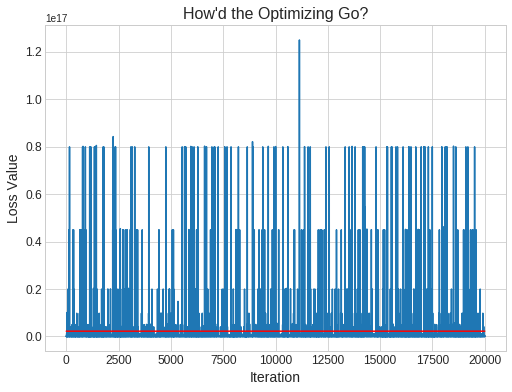

In [23]:
train_neural_net(model, outcome_Tensor, predictors_Tensor,
                 cv_outcome_Tensor, cv_predictors_Tensor)

How'd the model perform on the data used to make it?

In [24]:
def plot_train_perf(train_predictors, train_obs):
    
    # Plots how well the model performs on training data
    # train_predictors = the values that the model predicts from, PyTorch Tensor
    # train_obs = what the model would ideally predict, PyTorch Tensor
    # Returns a plot
    
    
    # Get the predictions
    train_predictions = model(Variable(train_predictors, requires_grad = False))
    
    # Convert that to a numpy array
    train_predictions = train_predictions.data.numpy()
    
    # Put it in log-transformed scale and convert it to a list
    train_predictions = train_predictions.tolist()
    
    
    # Put the observed outcomes in log-transformed scale
    # and convert it to a list
    train_obs = train_obs.numpy().tolist()
    
    
    # Plot it
    plt.scatter(train_obs, train_predictions, facecolors = "none", edgecolors = "k")
    axes = plt.gca()
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    axes.set_xlim([min(train_obs)[0], max(train_obs)[0]])
    axes.set_ylim([min(train_obs)[0], max(train_obs)[0]])
    axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)", size = 14)
    axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)", size = 14)
    axes.set_title("Model Performance on Training Data", size = 16)
    plt.plot([min(train_obs)[0], max(train_obs)[0]],
             [min(train_obs)[0], max(train_obs)[0]],
             'r', lw = 1)

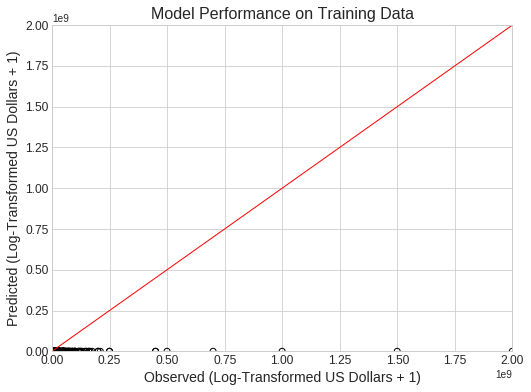

In [25]:
plot_train_perf(predictors_Tensor, outcome_Tensor)

### 1.2 Performance Visualization

In log-transformed space, plot predicted values versus observed values for new data

In [26]:
def plot_cross_valid_perf(cv_predictors, cv_obs):
    
    # Plots how well the model performs on new data
    # cv_pred = the values that the model predicts from, PyTorch Tensor
    # cv_obs = what the model would ideally predict, PyTorch Tensor
    # Returns a plot
    
    
    # Convert to a PyTorch Variable and get the predictions
    cv_predictions = model(Variable(cv_predictors, requires_grad = False))
    
    # Convert that to a numpy array
    cv_predictions = cv_predictions.data.numpy()
    
    # Put it in log-transformed scale and convert it to a list
    cv_predictions = cv_predictions.tolist()
    
    
    # Put the observed outcomes in log-transformed scale
    # and convert it to a list
    cv_obs = cv_obs.numpy().tolist()
    
    
    # Plot it
    plt.scatter(cv_obs, cv_predictions, facecolors = "none", edgecolors = "k")
    axes = plt.gca()
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    axes.set_xlim([min(cv_obs)[0], max(cv_obs)[0]])
    axes.set_ylim([min(cv_obs)[0], max(cv_obs)[0]])
    axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)", size = 14)
    axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)", size = 14)
    axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)")
    axes.set_title("Model Performance on Cross-Validation Data", size = 16)
    plt.plot([min(cv_obs)[0], max(cv_obs)[0]],
             [min(cv_obs)[0], max(cv_obs)[0]],
             'r', lw = 1)

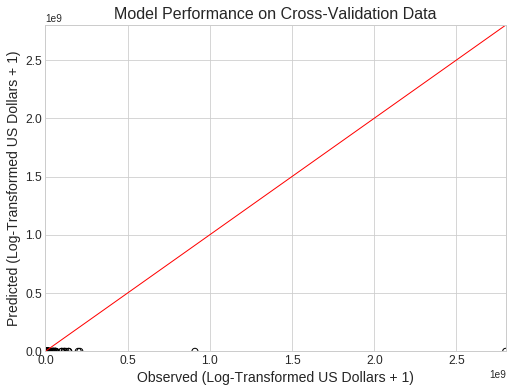

In [27]:
plot_cross_valid_perf(cv_predictors_Tensor, cv_outcome_Tensor)

In [28]:
def compute_MSE(predictors, observed_outcomes):
    
    # Computes the mean squared error of the model
    # predictors = the variables and values used in prediction
    # observed_outcomes = what the prediction would ideally yield
    # Returns a PyTorch Variable
    
    
    # Get the validation set predictions
    cv_predictions = model(Variable(predictors, requires_grad = False))
    
    # Get the validation set outcomes
    cv_outcomes = Variable(observed_outcomes)
    
    
    # Get the loss - (total) residual sum of squares
    total_SE = loss_fn(cv_predictions, cv_outcomes)
    
    # Average that to get mean square error
    mean_SE = total_SE / len(predictors)
    return(mean_SE)

In [29]:
MSE = compute_MSE(cv_predictors_Tensor, cv_outcome_Tensor)
MSE

Variable containing:
 2.2292e+15
[torch.FloatTensor of size 1]

## 1. With Over Sampling of Extreme Events

In [30]:
# Define the neural network
class Net(torch.nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(34, 23)
        self.fc2 = torch.nn.Linear(23, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        return(x)


# Make it
model = Net()

In [31]:
def train_with_oversamp(model, train_outcomes, train_inputs,
                        cv_outcomes, cv_inputs):
    
    # This function will train the neural network and produce a loss versus iteration plot
    # model = the model architecture, a Net class
    # train_outcomes = the right answers, PyTorch Tensor
    # train_inputs = what we're using to get to the right answers, PyTorch Tensor
    # cv_outcomes = the right answers of the new data, PyTorch Tensor
    # cv_inputs = what we're using to get the new right answers, PyTorch Tensor
    # Returns a plot and a trained Net
    
    
    # Make the outcomes into a Torch Variable
    outcome_Variable = Variable(train_outcomes)
    
    # Make the cv outcomes into a Torch Variable
    cv_outcome_Variable = Variable(cv_outcomes,
                                   requires_grad = False)
    
    # Make the predictors into a Torch Variable
    predictors_Variable = Variable(train_inputs,
                                   requires_grad = False)
    
    # Make the cv predictors into a Torch Variable
    cv_predictors_Variable = Variable(cv_inputs,
                                      requires_grad = False)
    
    
    # Make an empty list to add to for each iteration
    current_loss_value_mini = []
    
    # For the cv too
    current_cv_loss_value = []
    
    
    # Set the optimizer
    optimizer = torch.optim.Adagrad(model.parameters(), lr = 1e-2)
    
    
    # Train the neural network
    for t in range(20000):
        
        # Get the current mini-batch indices
        # Using probabilities that over sample the extreme events
        indices = torch.LongTensor(np.random.choice(remade_tor_df['easy_index'],
                                                    p = remade_tor_df['fixed_prob'],
                                                    size = 50, replace = False))
        
        # Get the current mini-batches
        predictors_mini = predictors_Variable[indices]
        outcome_mini = outcome_Variable[indices]
        
        # Get the current predictions
        current_pred_mini = model(predictors_mini)
        cv_pred = model(cv_predictors_Variable)
        
        # Compute current losses and and append that to the empty list
        current_loss_mini = loss_fn(current_pred_mini, outcome_mini)
        current_loss_value_mini.append(current_loss_mini.data[0])
        
        current_cv_loss = loss_fn(cv_pred, cv_outcome_Variable)
        current_cv_loss_value.append(current_cv_loss.data[0])
        
        # Zero the gradients before backwards pass
        optimizer.zero_grad()
        
        # Backwards pass
        current_loss_mini.backward()
        
        # Update model parameters
        optimizer.step()
    
    
    # Get iterations as a list for x-axis of plot
    iterations = list(range(0, 20000))
    
    
    # Convert total square error to mean square error
    mse = (np.asarray(current_loss_value_mini) / len(predictors_mini)).tolist()
    
    # For cv too
    mse_cv = (np.asarray(current_cv_loss_value) / len(cv_predictors_Variable)).tolist()
    
    
    # Plot loss versus iteration
    plt.plot(iterations, mse)
    plt.plot(iterations, mse_cv, "r-")
    plt.xlabel("Iteration", size = 14)
    plt.ylabel("Loss Value", size = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.title("How'd the Optimizing Go?", size = 16)

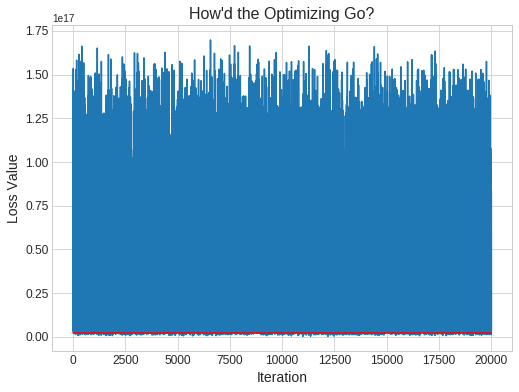

In [32]:
train_with_oversamp(model, outcome_Tensor, predictors_Tensor,
                    cv_outcome_Tensor, cv_predictors_Tensor)

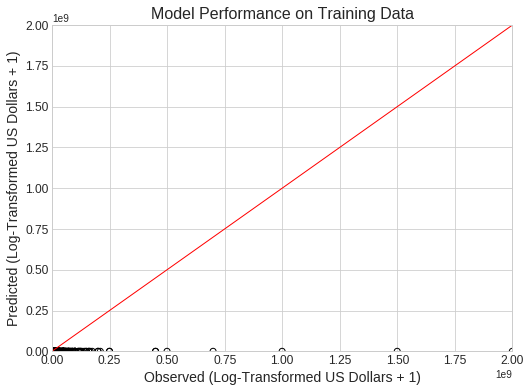

In [33]:
plot_train_perf(predictors_Tensor, outcome_Tensor)

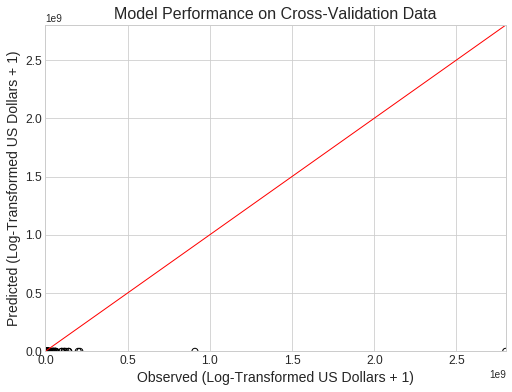

In [34]:
plot_cross_valid_perf(cv_predictors_Tensor, cv_outcome_Tensor)

In [35]:
MSE = compute_MSE(cv_predictors_Tensor, cv_outcome_Tensor)
MSE

Variable containing:
 2.2292e+15
[torch.FloatTensor of size 1]

## 2. Model with Mean-Normalized Output

In [36]:
# Get and store mean used for processing for the training set
mu = np.repeat(np.mean(outcome_Tensor.numpy()), len(outcome_Tensor))

mu = torch.from_numpy(mu)

# ... For the cv set - needed because these sets differ in length
# The values will be the same
mu_for_cv = np.repeat(np.mean(outcome_Tensor.numpy()), len(cv_outcome_Tensor))

mu_for_cv = torch.from_numpy(mu_for_cv)

# ... For the test set
mu_for_test = np.repeat(np.mean(outcome_Tensor.numpy()), len(test_outcome_Tensor))

mu_for_test = torch.from_numpy(mu_for_test)


# Get and store standard deviation used for processing
sigma = np.repeat(np.std(outcome_Tensor.numpy()), len(outcome_Tensor))

sigma = torch.from_numpy(sigma)

# ... For the cv set
sigma_for_cv = np.repeat(np.std(outcome_Tensor.numpy()), len(cv_outcome_Tensor))

sigma_for_cv = torch.from_numpy(sigma_for_cv)

# ... For the test set
sigma_for_test = np.repeat(np.std(outcome_Tensor.numpy()), len(test_outcome_Tensor))

sigma_for_test = torch.from_numpy(sigma_for_test)

In [37]:
# Process the training data and store it as a new Tensor
outcome_Tensor2 = (outcome_Tensor - mu) / sigma
outcome_Tensor2 = outcome_Tensor2 - outcome_Tensor2.min()

# Same for the cv set
cv_outcome_Tensor2 = (cv_outcome_Tensor - mu_for_cv) / sigma_for_cv
cv_outcome_Tensor2 = cv_outcome_Tensor2 - outcome_Tensor2.min()

# Same for the test set
test_outcome_Tensor2 = (test_outcome_Tensor - mu_for_test) / sigma_for_test
test_outcome_Tensor2 = test_outcome_Tensor2 - outcome_Tensor2.min()

In [38]:
# Define the neural network
class Net(torch.nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(34, 23)
        self.fc2 = torch.nn.Linear(23, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return(x)


# Make it
model = Net()

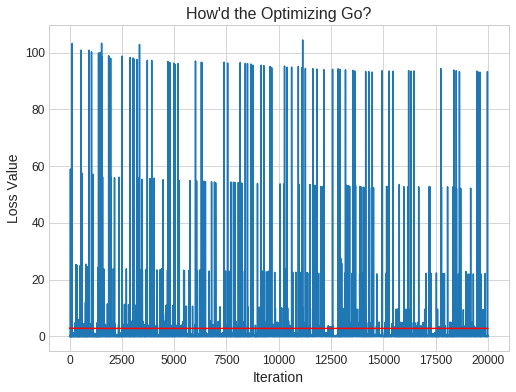

In [39]:
train_neural_net(model, outcome_Tensor2, predictors_Tensor,
                 cv_outcome_Tensor2, cv_predictors_Tensor)

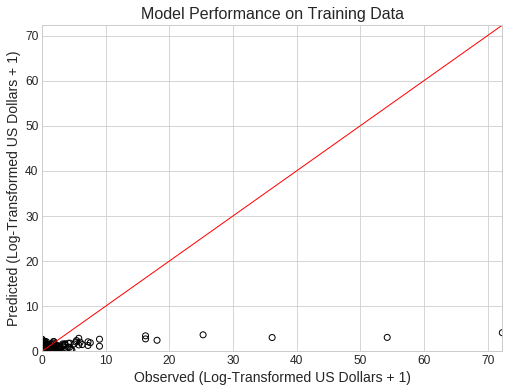

In [40]:
plot_train_perf(predictors_Tensor, outcome_Tensor2)

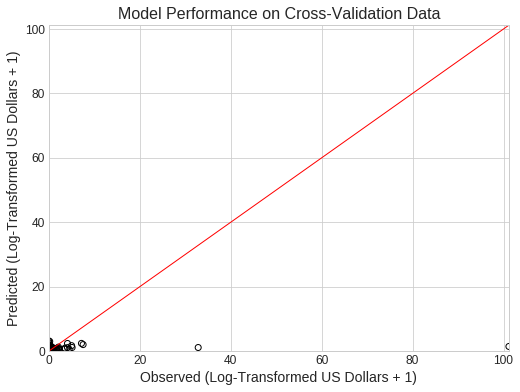

In [41]:
plot_cross_valid_perf(cv_predictors_Tensor, cv_outcome_Tensor2)

In [42]:
MSE = compute_MSE(cv_predictors_Tensor, cv_outcome_Tensor2)
MSE

Variable containing:
 2.8425
[torch.FloatTensor of size 1]

## 2. With Over Sampling of Extreme Events

In [43]:
# Define the neural network
class Net(torch.nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(34, 23)
        self.fc2 = torch.nn.Linear(23, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return(x)


# Make it
model = Net()

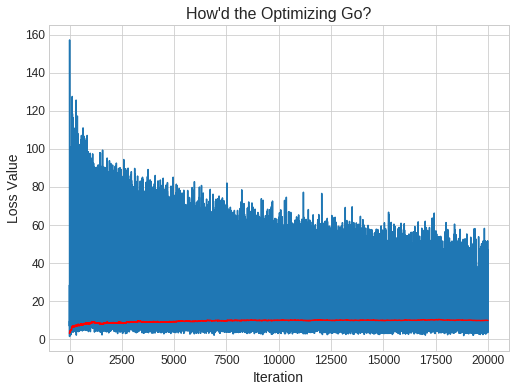

In [44]:
train_with_oversamp(model, outcome_Tensor2, predictors_Tensor,
                    cv_outcome_Tensor2, cv_predictors_Tensor)

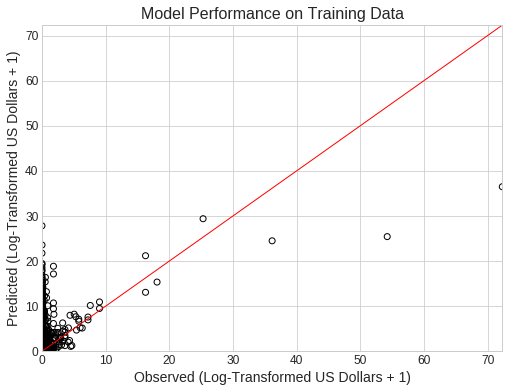

In [45]:
plot_train_perf(predictors_Tensor, outcome_Tensor2)

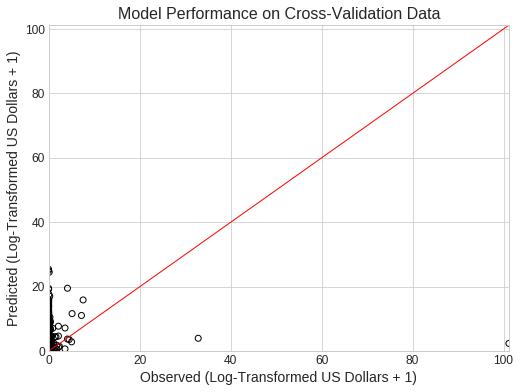

In [46]:
plot_cross_valid_perf(cv_predictors_Tensor, cv_outcome_Tensor2)

In [47]:
MSE = compute_MSE(cv_predictors_Tensor, cv_outcome_Tensor2)
MSE

Variable containing:
 9.8023
[torch.FloatTensor of size 1]

## 3. Trying Feature Scaling

In [48]:
# Feature scale the training set
outcome_Tensor3 = (outcome_Tensor - outcome_Tensor.max()) / (outcome_Tensor.max() - outcome_Tensor.min())

# And the cv set
cv_outcome_Tensor3 = (cv_outcome_Tensor - outcome_Tensor.max()) / (outcome_Tensor.max() - outcome_Tensor.min())

# And the test set
test_outcome_Tensor3 = (test_outcome_Tensor - outcome_Tensor.max()) / (outcome_Tensor.max() - outcome_Tensor.min())

In [49]:
# Define the neural network
class Net(torch.nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(34, 23)
        self.fc2 = torch.nn.Linear(23, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return(x)


# Make it
model = Net()

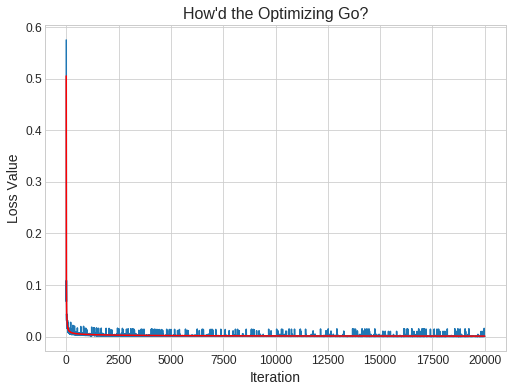

In [50]:
train_neural_net(model, outcome_Tensor3, predictors_Tensor,
                 cv_outcome_Tensor3, cv_predictors_Tensor)

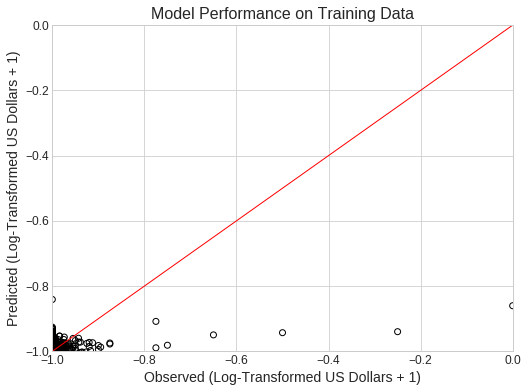

In [51]:
plot_train_perf(predictors_Tensor, outcome_Tensor3)

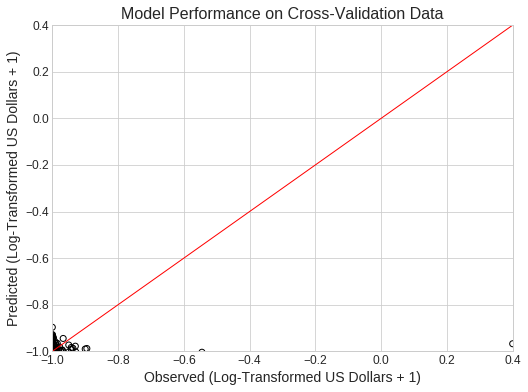

In [52]:
plot_cross_valid_perf(cv_predictors_Tensor, cv_outcome_Tensor3)

In [53]:
MSE = compute_MSE(cv_predictors_Tensor, cv_outcome_Tensor3)
MSE

Variable containing:
1.00000e-04 *
  8.1381
[torch.FloatTensor of size 1]

## 3. With Over Sampling of Extreme Events

In [54]:
# Define the neural network
class Net(torch.nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(34, 23)
        self.fc2 = torch.nn.Linear(23, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return(x)


# Make it
model = Net()

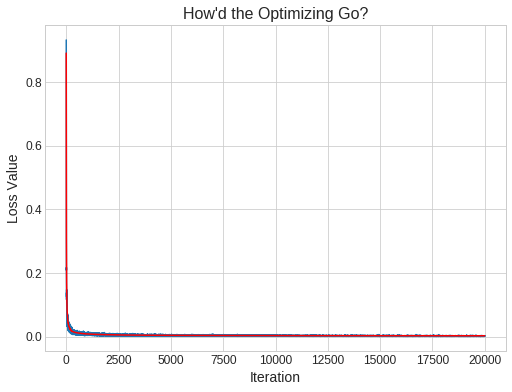

In [55]:
train_with_oversamp(model, outcome_Tensor3, predictors_Tensor,
                    cv_outcome_Tensor3, cv_predictors_Tensor)

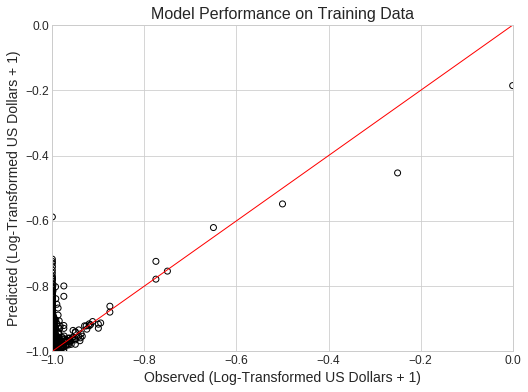

In [56]:
plot_train_perf(predictors_Tensor, outcome_Tensor3)

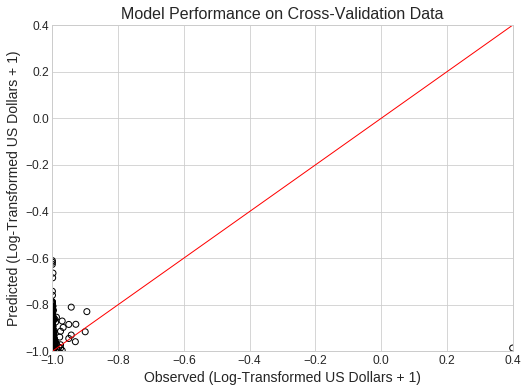

In [57]:
plot_cross_valid_perf(cv_predictors_Tensor, cv_outcome_Tensor3)

In [58]:
MSE = compute_MSE(cv_predictors_Tensor, cv_outcome_Tensor3)
MSE

Variable containing:
1.00000e-03 *
  2.7107
[torch.FloatTensor of size 1]

Nothing here has proven particularly promising; perhaps the zero-included models are impossible or just *really* tricky.